# Libraries

In [2]:
import torch
from torch.utils.data import Subset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
import numpy as np

device: cuda


# Function & Classes

In [2]:
def get_subset_indices(dataset, percentage, seed=0):
  rng = np.random.RandomState(seed)
  data = dataset.data
  targets = np.array(dataset.targets)
  num_classes = len(np.unique(targets))
  num_samples_per_class = int(percentage*len(dataset)/num_classes)

  indices = []

  for c in range(num_classes):
    class_indices = (targets == c).nonzero()[0]
    indices.extend(
        list(rng.choice(class_indices, size=num_samples_per_class, replace=False))
    )
  return indices

import torch.nn as nn
import torch.nn.functional as F

def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * \
                (1 + np.cos(step / total_steps * np.pi))

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,
                               planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes,
                          self.expansion * planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False), nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,
                               planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes,
                               self.expansion * planes,
                               kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes,
                          self.expansion * planes,
                          kernel_size=1,
                          stride=stride,
                          bias=False), nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18_32x32(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=None, num_classes=10):
        super(ResNet18_32x32, self).__init__()
        if num_blocks is None:
            num_blocks = [2, 2, 2, 2]
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # self.avgpool = nn.AvgPool2d(4)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.feature_size = 512 * block.expansion

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, return_feature=False, return_feature_list=False):
        feature1 = F.relu(self.bn1(self.conv1(x)))
        feature2 = self.layer1(feature1)
        feature3 = self.layer2(feature2)
        feature4 = self.layer3(feature3)
        feature5 = self.layer4(feature4)
        feature5 = self.avgpool(feature5)
        feature = feature5.view(feature5.size(0), -1)
        logits_cls = self.fc(feature)
        feature_list = [feature1, feature2, feature3, feature4, feature5]
        if return_feature:
            return logits_cls, feature
        elif return_feature_list:
            return logits_cls, feature_list
        else:
            return logits_cls

    def forward_threshold(self, x, threshold):
        feature1 = F.relu(self.bn1(self.conv1(x)))
        feature2 = self.layer1(feature1)
        feature3 = self.layer2(feature2)
        feature4 = self.layer3(feature3)
        feature5 = self.layer4(feature4)
        feature5 = self.avgpool(feature5)
        feature = feature5.clip(max=threshold)
        feature = feature.view(feature.size(0), -1)
        logits_cls = self.fc(feature)

        return logits_cls

    def get_fc(self):
        fc = self.fc
        return fc.weight.cpu().detach().numpy(), fc.bias.cpu().detach().numpy()

# Dataset

In [3]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

"""# Optimizer & Scheduler & DataLoader function with perc as parameter
## Notice that all three should adjust with the data size so it will be adjusted alongside with the data percentage
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

def dataloader_with_seed_perc(seed, perc):
  train_subset = Subset(
      trainset, 
      get_subset_indices(trainset, perc, int(seed))
  )
  
  trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=128, shuffle=True, num_workers=2)

  return trainloader

def optimizer_with_lr(net, lr):
  optimizer = torch.optim.SGD(
    net.parameters(),
    lr,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True,
)
  return optimizer

def schedular_with_lr(opt, lr, trainloader):
  scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt,
    lr_lambda=lambda step: cosine_annealing(
        step,
        EPOCHS * len(trainloader),
        1,
        1e-6 / lr,
    ),
)
  return scheduler

Files already downloaded and verified
Files already downloaded and verified


# Test and save accu to list

In [4]:
"""# Checkpoint Folder"""

import os, sys
ID_CHECKPOINT_FOLDER = "./saved_model"
GID_CHECKPOINT_FOLDER = "./gid_saved_model"

"""# Test"""
DATA_ROOT = "./data"
BATCH_SIZE = 100
test_acc_list = []
for SEED_index in range(0, 3):
    for perc_index in range(1, 12, 1):
        if perc_index <= 10:
            perc = perc_index/10.0
            net = ResNet18_32x32()
            print(ID_CHECKPOINT_FOLDER+"/seed_"+str(SEED_index)+"_perc_"+str(perc)+".pth")
            state_dict = torch.load(ID_CHECKPOINT_FOLDER+"/seed_"+str(SEED_index)+"_perc_"+str(perc)+".pth")
            net.load_state_dict(state_dict)
            net.cuda()
            net.eval()
            total_examples = 0
            correct_examples = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                total_examples += targets.shape[0]
                correct_examples += correct
            avg_acc = correct_examples / total_examples
            test_acc_list.append(avg_acc.cpu().detach().item())
        else:
            net = ResNet18_32x32()
            perc = 1.0
            print(GID_CHECKPOINT_FOLDER+"/seed_"+str(SEED_index)+"_perc_"+str(perc)+".pth")
            state_dict = torch.load(GID_CHECKPOINT_FOLDER+"/gid_seed_"+str(SEED_index)+"_perc_"+str(perc)+".pth")
            net.load_state_dict(state_dict)
            net.cuda()
            net.eval()
            total_examples = 0
            correct_examples = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                total_examples += targets.shape[0]
                correct_examples += correct
            avg_acc = correct_examples / total_examples
            test_acc_list.append(avg_acc.cpu().detach().item())
print(test_acc_list)

./saved_model/seed_0_perc_0.1.pth
./saved_model/seed_0_perc_0.2.pth
./saved_model/seed_0_perc_0.3.pth
./saved_model/seed_0_perc_0.4.pth
./saved_model/seed_0_perc_0.5.pth
./saved_model/seed_0_perc_0.6.pth
./saved_model/seed_0_perc_0.7.pth
./saved_model/seed_0_perc_0.8.pth


[0.74839997 0.86659998 0.90259999 0.9149     0.92859995 0.9382
 0.94089997 0.94489998 0.94929999 0.9522     0.93919998]
[0.76730001 0.86849999 0.89599997 0.91579998 0.93049997 0.93349999
 0.94169998 0.94759995 0.95139998 0.9522     0.93739998]
[0.78189999 0.86109996 0.89949995 0.91459996 0.92479998 0.93159997
 0.94319999 0.94619995 0.9497     0.9522     0.94019997]


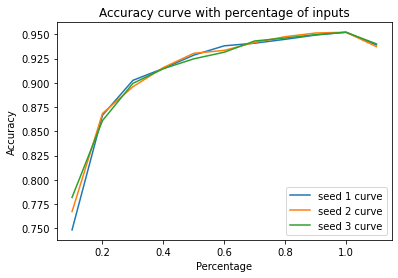

In [ ]:
import matplotlib.pyplot as plt
perc_array = np.arange(11)
acc_array = np.zeros((11), dtype=float)
for i in range(0, 3):
    for j in range(0, 11):
        acc_array[j] = test_acc_list[i*11+j]
    label = "seed "+ str(i+1)+ " curve"
    x_array = (perc_array + 1)*1.0/10
    plt.plot(x_array, acc_array, label = label)
    print(acc_array)
plt.title('Accuracy curve with percentage of inputs')
plt.xlabel('Percentage')
plt.ylabel('Accuracy')
plt.legend()